# Bootstrap Method for Two Samples 

This notebook will introduce the bootstrap method for comparison two groups.

In [1]:
import numpy as np
import pandas as pd
#from scipy import stats as st
from statsmodels.stats import weightstats as stests
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  

## Bootstrap method for two independent samples

The bootstrap method idea is simple: "If there is no difference between two treatments, a particular score is just as likely to end up in one group as in the other."

The bootstrap method allows us to make inferences on the population from which the data are a random sample, regardless of the shape of the population distribution.

The first step is to transform the two samples we want to compare into others that share the mean.

Let's work with classes C and D.

We will test `Ho: mean(classC) = mean(classD)` without assuming equal variances. We need estimates of classC and classD that use only the assumption of the common mean.

Let's `x` be the combined sample. `x` is the result of concatenating classes C and D.

Let's generate values for classes C and D:

In [2]:
np.random.seed(123)
classC = np.random.normal(85, 3, 100)
classD = np.random.normal(90, 3, 95)

Notice that the means of `classC` and `classD` are different.

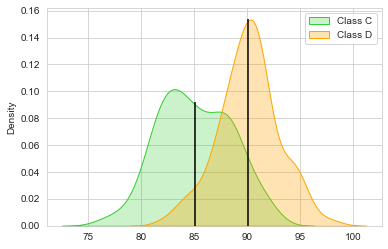

In [3]:
ax=sns.kdeplot(x=classC, color='limegreen', shade=True, label='Class C')
ax.vlines(x=np.mean(classC), ymin=0, ymax=0.092, color='black')
ax=sns.kdeplot(x=classD, color='orange', shade=True, alpha=0.3, label='Class D')
ax.vlines(x=np.mean(classD), ymin=0, ymax=0.154, color='black')
plt.legend();

In [4]:
print('Mean of class C = %.2f' % np.mean(classC))
print('Mean of class D = %.2f' % np.mean(classD))

Mean of class C = 85.08
Mean of class D = 90.07


Notice that the number of students in each class is also different.

In [5]:
print('Lenght of class C =', len(classC))
print('Lenght of class D =', len(classD))

Lenght of class C = 100
Lenght of class D = 95


Let's transform the original samples into others that share their means.

In [6]:
def combined_mean(sample1, sample2):
    '''
    It concatenates sample1 with sample2
    and returns the combined mean.
    '''
    x = np.concatenate((sample1, sample2))
    return(np.mean(x))

In [7]:
cmean = combined_mean(classC, classD)
print('Mean of combined sample = %.2f' % cmean)

Mean of combined sample = 87.51


Creating classCt (class C transformed) and classDt (class D transformed)

In [8]:
classCt = classC - np.mean(classC) + cmean
classDt = classD - np.mean(classD) + cmean

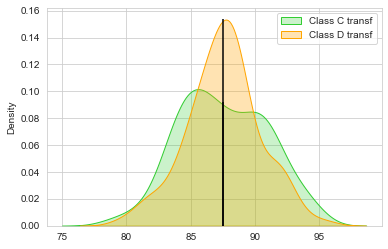

In [9]:
ax=sns.kdeplot(x=classCt, shade=True, color='limegreen', label='Class C transf')
ax.vlines(x=np.mean(classCt), ymin=0, ymax=0.092, color='black')
ax=sns.kdeplot(x=classDt, shade=True, color='orange', alpha=0.3, label='Class D transf')
ax.vlines(x=np.mean(classDt), ymin=0, ymax=0.154, color='black')

plt.legend();

In [10]:
print('Mean of shifted class C = %.2f' % np.mean(classCt))
print('Mean of shifted class D = %.2f' % np.mean(classDt))

Mean of shifted class C = 87.51
Mean of shifted class D = 87.51


`generateSamples` is the function for generating samples WITH replacement.

In [11]:
def generateSamples(sample_data, num_samples=10000, sample_size=100):
    '''
    It returns a DataFrame where each column is a sample (with replacement).
    '''
    dfSamples = pd.DataFrame()
    for k in range(num_samples):
        sample = np.random.choice(sample_data, size=sample_size)
        column_name = 'Sample'+str(k)
        dfSamples[column_name] = sample
    return(dfSamples)  

Let's generate two DataFrames of generated samples with replacement: one for `classCt` and the other for `classDt`

In [12]:
df_C = generateSamples(classCt, num_samples=10000, sample_size=50)
print(df_C.shape)

(50, 10000)


In [13]:
df_D = generateSamples(classDt, num_samples=10000, sample_size=50)
print(df_D.shape)

(50, 10000)


### Statistic: difference of means

In [14]:
dMeans = np.mean(classC) - np.mean(classD)

In [15]:
sample_distribution_dMeans = df_C.mean() - df_D.mean()

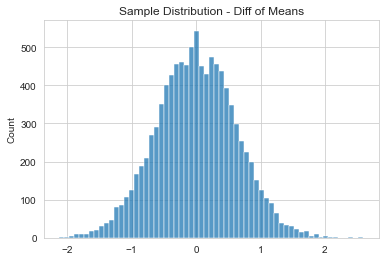

In [16]:
sns.histplot(x=sample_distribution_dMeans).set(title='Sample Distribution - Diff of Means');

In [17]:
def twoSamplesHT(self, stat='mean', alpha=0.05, alternative='two-sided'):
    '''
    It computes the bootstrap two-samples test.
    stat: 'mean', 'median', 't'
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
    '''
    print('     Sample 1 \t Sample 2')
    print('Mean: %.2f \t %.2f' %(np.mean(self.sample1), np.mean(self.sample2)))
    print('Var:  %.2f \t %.2f' %(np.var(self.sample1), np.var(self.sample2)))
    print('n:    %i \t %i' %(len(self.sample1), len(self.sample2)))
    #sigHo = {'two-sided':' =', 'smaller':'>=', 'larger':'<='}
    sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
    print('--- Bootstrapping Method ---')
    #print('    Ho: mean(sample1)  = mean(sample2)') 
    #print('    Ha: mean(sample1)', sigHa[alternative], 'mean(sample2)')  
    #self.two.sample_distribution_Ho =   
    self.two.createSampleDistributionHo(0)
    p_val = self.two.getpValue(self.two.obs_value, alpha, alternative)
    print('    p-value = '+str(np.round(p_val,4)))

In [18]:
def getpValue(sample_distribution, obs_value, alpha=0.05, alternative='two-sided'):
    '''
    sample_distribution: the sample distribution
    obs_value: observed value 
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        if obs_value < np.mean(sample_distribution): 
            p_val = 2*ecdf(obs_value)
        else: 
            p_val = 2*(1-ecdf(obs_value)) 
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [19]:
def hyp_test(sampl_value, sampl_distribution, alpha=0.05, alternative='two-sided'):
    '''
    sampl_value: observed value calculated from the sample
    sampl_distribution: sample distribution calculated from the sample
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', and 'larger'
    '''
    sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
    print('--- Bootstrap Hypothesis Test ---')
    print('    Sample Mean = %.2f' %(sampl_value))  
    ax = sns.kdeplot(x=sampl_distribution, color='lightskyblue', shade=True, alpha=0.4)
    plt.axvline(x=sampl_value, ymin=0, ymax= 0.03, color='black', linewidth=6)
    plt.title('Sampling Distribution')
    p_val = getpValue(sampl_distribution, sampl_value, alpha, alternative)
    if alternative=='two-sided':
        cv1 = np.round(np.percentile(sampl_distribution, (alpha/2)*100),2)    
        cv2 = np.round(np.percentile(sampl_distribution, 100-alpha*100),2)     
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
    elif alternative=='smaller':
        cv1 = np.round(np.percentile(sampl_distribution, alpha*100),2)  
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    else:
        cv2 = np.round(np.percentile(sampl_distribution, 100-alpha*100),2)  
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('    p-value = '+str(np.round(p_val,4)))

--- Bootstrap Hypothesis Test ---
    Sample Mean = -4.99
    p-value = 0.0


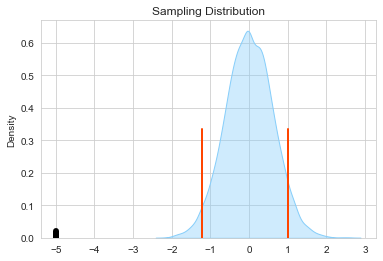

In [20]:
hyp_test(dMeans, sample_distribution_dMeans)

### Statistic: difference of medians

In [21]:
dMedians = np.median(classC) - np.median(classD) 

In [22]:
sample_distribution_dMedians = df_C.median() - df_D.median()

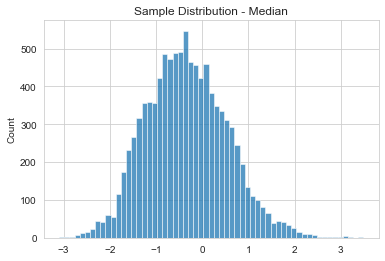

In [23]:
sns.histplot(x=sample_distribution_dMedians).set(title='Sample Distribution - Median');

--- Bootstrap Hypothesis Test ---
    Sample Mean = -5.44
    p-value = 0.0


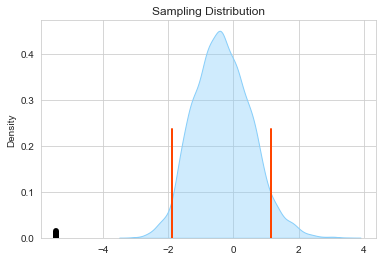

In [24]:
hyp_test(dMedians, sample_distribution_dMedians)

### Statistic: t-test

The following function calculates the `t-statistic` for the original two samples.

In [25]:
def t(sample1, sample2):
    n=len(sample1)
    m=len(sample2)
    denom=np.sqrt(np.var(sample1)/n+np.var(sample2)/m)
    return((np.mean(sample1)-np.mean(sample2))/denom)

In [26]:
t = t(classC, classD)

Let's define a function for calculating the sample distribution `t` using both DataFrames.

In [27]:
def createSampleDistributionT(df1, df2):
    '''
    It calculates the t statistic for all
    columns in both DataFrames.
    '''
    n=df1.shape[0]
    m=df2.shape[0]
    denom=np.sqrt(df1.var()/n + df2.var()/m)
    return(list((df1.mean()-df2.mean())/denom))

In [28]:
sample_distribution_t = createSampleDistributionT(df_C, df_D)

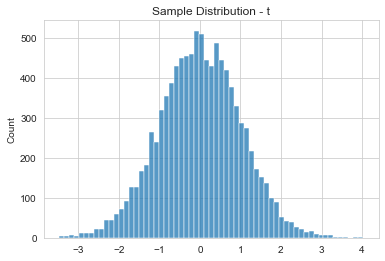

In [29]:
sns.histplot(x=sample_distribution_t).set(title='Sample Distribution - t');

--- Bootstrap Hypothesis Test ---
    Sample Mean = -11.22
    p-value = 0.0


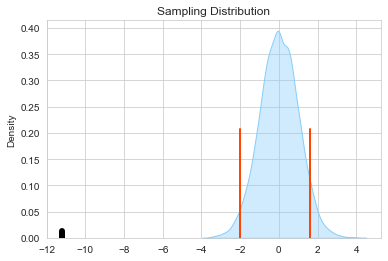

In [30]:
hyp_test(t, sample_distribution_t)

### Summarizing using classes

Let's use the previous classes definitions to create another one to summarize the process.

In [31]:
import goliathBootstrap as gb

`TwoIndSamplesHT` is the new class for the two independent samples hypothesis test using the bootstrapping method.

In [32]:
class TwoIndSamplesHT():
    '''
    '''

    def __init__(self, sample1, sample2, num_samples=10000, sample_size=100, stat='mean'):
        '''
        sample1 and sample2 are the two independent samples to be compared
        '''

        self.stat = stat
        self.sample1 = sample1
        self.sample2 = sample2

        tsample1, tsample2 = self.transformingSamples()  

        if self.stat == 'median':
            self.tsample1 = gb.goliathBootstrap(tsample1, num_samples, sample_size, func=np.median) 
            self.tsample2 = gb.goliathBootstrap(tsample2, num_samples, sample_size, func=np.median) 
        else:
            self.tsample1 = gb.goliathBootstrap(tsample1, num_samples, sample_size, func=np.mean) 
            self.tsample2 = gb.goliathBootstrap(tsample2, num_samples, sample_size, func=np.mean)     


        self.two = gb.OneSampleHT([1,2,3], num_samples=5, sample_size=2) 

        if self.stat == 'median': 
            self.dMedians()
        elif self.stat == 't':    
            self.tStat()   
        else:                
            self.dMeans()  


           
    def transformingSamples(self):
        '''
        It transforms sample1 and sample2 into two new samples tsample1 
        and tsample2, that share their mean.
        '''
        # Calculating combined_mean
        combined_sample = np.concatenate((self.sample1, self.sample2))
        combined_mean = np.mean(combined_sample)
        
        tsample1 = self.sample1 - np.mean(self.sample1) + combined_mean
        tsample2 = self.sample2 - np.mean(self.sample2) + combined_mean
        return(tsample1, tsample2)



    def graphSampleDistribution(self):
        '''
        '''
        self.two.graphSampleDistribution()



    def dMeans(self):    
        '''
        statistic: difference of means 
        Use the difference of means as statistic for hypothesis testing.
        The sample distribution is computed using the difference of means.
        '''
        if self.tsample1.statistic != np.mean:
            self.tsample1.createSampleDistribution(func=np.mean)
            self.tsample2.createSampleDistribution(func=np.mean)
        sample_distribution = self.tsample1.sample_distribution - self.tsample2.sample_distribution
        self.two.setSampleDistribution(sample_distribution, func=np.mean)
        self.two.obs_value = np.mean(self.sample1) - np.mean(self.sample2)



    def dMedians(self):
        '''
        statistic: difference of medians 
        Use the difference of medians as statistic for hypothesis testing.
        The sample distribution is computed using the difference of medians.
        '''
        if self.tsample1.statistic != np.median:
            self.tsample1.createSampleDistribution(func=np.median)
            self.tsample2.createSampleDistribution(func=np.median)
        sample_distribution = self.tsample1.sample_distribution - self.tsample2.sample_distribution
        self.two.setSampleDistribution(sample_distribution, func=np.median)
        self.two.obs_value = np.median(self.sample1) - np.median(self.sample2)



    def tStat(self):
        '''
        statistic: t-statistic 
        Use the t-statistic for hypothesis testing.
        The sample distribution is computed using the t-statistic.
        '''
        if self.tsample1.statistic != np.mean:
            self.tsample1.createSampleDistribution(func=np.mean)
            samp_dist_mean1 = self.tsample1.sample_distribution
            self.tsample2.createSampleDistribution(func=np.mean)
            samp_dist_mean2 = self.tsample2.sample_distribution
        self.tsample1.createSampleDistribution(func=np.var)
        samp_dist_var1 = self.tsample1.sample_distribution
        samp_dist_n1    = self.tsample1.sample_size
        self.tsample2.createSampleDistribution(func=np.var)
        samp_dist_var2 = self.tsample2.sample_distribution
        samp_dist_n2    = self.tsample2.sample_size
        # Calculating sample_distribution
        denom = np.sqrt(samp_dist_var1/samp_dist_n1 + samp_dist_var2/samp_dist_n2)
        sample_distribution = (samp_dist_mean1 - samp_dist_mean2)/denom
        self.two.setSampleDistribution(sample_distribution, func=np.var)
        # Calculating obs_value
        n=len(self.sample1)
        m=len(self.sample2)
        denom=np.sqrt(np.var(self.sample1)/n + np.var(self.sample2)/m)
        self.two.obs_value = (np.mean(self.sample1)-np.mean(self.sample2))/denom



    def twoIndSamplesHT(self, stat='mean', alpha=0.05, alternative='two-sided'):
        '''
        It computes the bootstrap two independent samples test.
        stat: 'mean', 'median', 't'
        alpha: significance level
        alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
        '''
        print('     Sample 1 \t Sample 2')
        print('Mean: %.2f \t %.2f' %(np.mean(self.sample1), np.mean(self.sample2)))
        print('Var:  %.2f \t %.2f' %(np.var(self.sample1), np.var(self.sample2)))
        print('n:    %i \t %i' %(len(self.sample1), len(self.sample2)))
        #sigHo = {'two-sided':' =', 'smaller':'>=', 'larger':'<='}
        sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
        print('--- Bootstrapping Method ---')
        if stat == 'median':
            print('    Ho: median1 == median2')
            print('    Ha: median1', sigHa[alternative], 'median2')
            print('statistic: median1-median2')
            self.dMedians()
        elif stat == 't':    
            print('    Ho: mean1 == mean2')
            print('    Ha: mean1', sigHa[alternative], 'mean2')
            print('statistic: (mean1-mean2)/sqrt(var1/n1+var2/n2)')
            self.tStat()       
        else:
            print('    Ho: mean1 == mean2')
            print('    Ha: mean1', sigHa[alternative], 'mean2')
            print('statistic: mean1-mean2')
            self.dMeans()  
        self.two.createSampleDistributionHo(0)
        p_val = self.two.getpValue(self.two.obs_value, alpha, alternative)
        print('statistic = %.2f \t p-value = %.4f' %(self.two.obs_value, p_val))

     
    def graphTwoIndSamplesHT(self, stat='mean', alpha=0.05, alternative='two-sided'):
        '''
        It computes the bootstrap two independent samples test and gets graphical results.
        stat: 'mean', 'median', 't'
        alpha: significance level
        alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
        '''
        print('      Sample 1 \t Sample 2')
        print('Mean: %.2f \t %.2f' %(np.mean(self.sample1), np.mean(self.sample2)))
        print('Var:  %.2f \t %.2f' %(np.var(self.sample1), np.var(self.sample2)))
        print('n:    %i \t %i' %(len(self.sample1), len(self.sample2)))
        #sigHo = {'two-sided':' =', 'smaller':'>=', 'larger':'<='}
        sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
        print('--- Bootstrapping Method ---')
        if stat == 'median':
            print('    Ho: median1 == median2')
            print('    Ha: median1', sigHa[alternative], 'median2')
            print('statistic: median1-median2')
            self.dMedians()
        elif stat == 't':    
            print('    Ho: mean1 == mean2')
            print('    Ha: mean1', sigHa[alternative], 'mean2')
            print('statistic: (mean1-mean2)/sqrt(var1/n1+var2/n2)')
            self.tStat()       
        else:
            print('    Ho: mean1 == mean2')
            print('    Ha: mean1', sigHa[alternative], 'mean2')
            print('statistic: mean1-mean2')
            self.dMeans()
        self.two.createSampleDistributionHo(0)
        p_val = self.two.graphpValue(self.two.obs_value, alpha, alternative)
        print('statistic = %.2f \t p-value = %.4f' %(self.two.obs_value, p_val))
        


In [33]:
My2S = TwoIndSamplesHT(classC, classD)

In [34]:
My2S.twoIndSamplesHT()

     Sample 1 	 Sample 2
Mean: 85.08 	 90.07
Var:  11.46 	 7.90
n:    100 	 95
--- Bootstrapping Method ---
    Ho: mean1 == mean2
    Ha: mean1 != mean2
statistic: mean1-mean2
statistic = -4.99 	 p-value = 0.0000


In [35]:
My2S.twoIndSamplesHT(alternative='smaller')

     Sample 1 	 Sample 2
Mean: 85.08 	 90.07
Var:  11.46 	 7.90
n:    100 	 95
--- Bootstrapping Method ---
    Ho: mean1 == mean2
    Ha: mean1 <  mean2
statistic: mean1-mean2
statistic = -4.99 	 p-value = 0.0000


      Sample 1 	 Sample 2
Mean: 85.08 	 90.07
Var:  11.46 	 7.90
n:    100 	 95
--- Bootstrapping Method ---
    Ho: mean1 == mean2
    Ha: mean1 <  mean2
statistic: mean1-mean2
statistic = -4.99 	 p-value = 0.0000


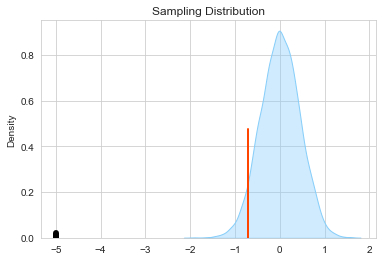

In [36]:
My2S.graphTwoIndSamplesHT(alternative='smaller')

      Sample 1 	 Sample 2
Mean: 85.08 	 90.07
Var:  11.46 	 7.90
n:    100 	 95
--- Bootstrapping Method ---
    Ho: median1 == median2
    Ha: median1 != median2
statistic: median1-median2
statistic = -5.44 	 p-value = 0.0000


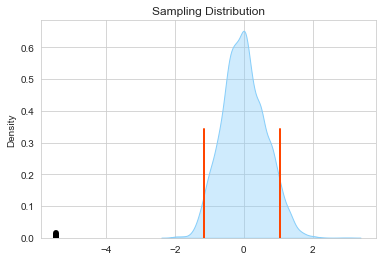

In [37]:
My2S.graphTwoIndSamplesHT(stat='median')

      Sample 1 	 Sample 2
Mean: 85.08 	 90.07
Var:  11.46 	 7.90
n:    100 	 95
--- Bootstrapping Method ---
    Ho: mean1 == mean2
    Ha: mean1 != mean2
statistic: (mean1-mean2)/sqrt(var1/n1+var2/n2)
statistic = -11.22 	 p-value = 0.0000


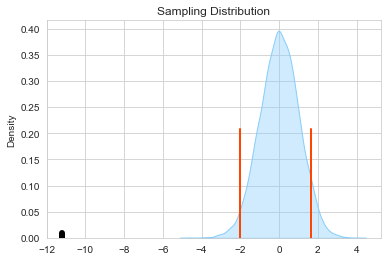

In [38]:
My2S.graphTwoIndSamplesHT(stat='t')

### Analysing new data

In [39]:
np.random.seed(123)
classE = np.random.normal(94.7, 2, 90)
classF = np.random.normal(95.1, 1.5, 95)

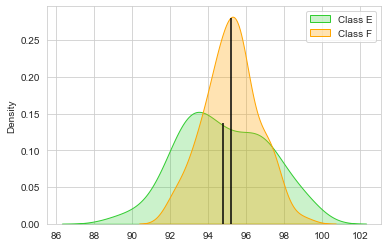

In [40]:
ax=sns.kdeplot(x=classE, color='limegreen', shade=True, label='Class E')
ax.vlines(x=np.mean(classE), ymin=0, ymax=0.137, color='black')
ax=sns.kdeplot(x=classF, color='orange', shade=True, alpha=0.3, label='Class F')
ax.vlines(x=np.mean(classF), ymin=0, ymax=0.28, color='black')
plt.legend();

In [41]:
My2S = TwoIndSamplesHT(classE, classF)

      Sample 1 	 Sample 2
Mean: 94.77 	 95.18
Var:  5.26 	 1.98
n:    90 	 95
--- Bootstrapping Method ---
    Ho: mean1 == mean2
    Ha: mean1 != mean2
statistic: mean1-mean2
statistic = -0.41 	 p-value = 0.1288


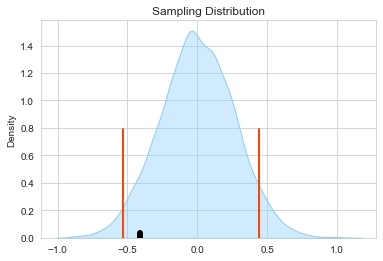

In [42]:
My2S.graphTwoIndSamplesHT()

      Sample 1 	 Sample 2
Mean: 94.77 	 95.18
Var:  5.26 	 1.98
n:    90 	 95
--- Bootstrapping Method ---
    Ho: median1 == median2
    Ha: median1 != median2
statistic: median1-median2
statistic = -0.69 	 p-value = 0.0806


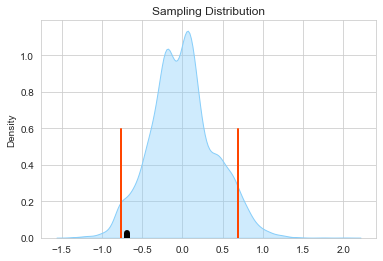

In [43]:
My2S.graphTwoIndSamplesHT(stat='median')

      Sample 1 	 Sample 2
Mean: 94.77 	 95.18
Var:  5.26 	 1.98
n:    90 	 95
--- Bootstrapping Method ---
    Ho: mean1 == mean2
    Ha: mean1 != mean2
statistic: (mean1-mean2)/sqrt(var1/n1+var2/n2)
statistic = -1.46 	 p-value = 0.1480


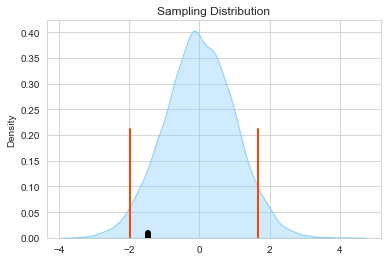

In [44]:
My2S.graphTwoIndSamplesHT(stat='t')

### Veryfing with the patametric test

In [45]:
def two_ind_ttest(sample1, sample2, alpha=0.05, alternative='two-sided'):
    '''
    Compare independend groups
    sample1: sample of values of population 1 (normally distributed)
    sample2: sample of values of population 2 (normally distributed)
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', and 'larger'  
    '''
    sigHo = {'two-sided':' =', 'smaller':'>=', 'larger':'<='}
    sigHa = {'two-sided':'!=', 'smaller':' <', 'larger':' >'}   
    print('--- Two independent sample t-test ---')
    #print('    H0: mean(sample1)  = mean(sample2)')
    print('    H1: mean(sample1)', sigHo[alternative], 'mean(sample2)')
    print('    H1: mean(sample1)', sigHa[alternative], 'mean(sample2)')
    print('Sample 1:   n = %i\tMean = %.2f\tStdDev = %.2f' %(len(sample1),np.mean(sample1), np.std(sample1)))
    print('Sample 2:   n = %i\tMean = %.2f,\tStdDev = %.2f' %(len(sample2),np.mean(sample2), np.std(sample2)))
    t_stat, pval, df = stests.ttest_ind(x1=sample1, x2=sample2, usevar='unequal', alternative=alternative)
    print('t-value = %.3f    df = %i    p-value = %.4f' %(t_stat,  df, pval))
    if pval < alpha:    # alpha value is 0.05 or 5%
        print("%.4f <= %.2f We are rejecting null hypothesis" %(pval, alpha))
    else:
        print("%.4f > %.2f We have no reason to reject the null hypothesis" %(pval, alpha))

In [46]:
two_ind_ttest(classC, classD)

--- Two independent sample t-test ---
    H1: mean(sample1)  = mean(sample2)
    H1: mean(sample1) != mean(sample2)
Sample 1:   n = 100	Mean = 85.08	StdDev = 3.38
Sample 2:   n = 95	Mean = 90.07,	StdDev = 2.81
t-value = -11.161    df = 189    p-value = 0.0000
0.0000 <= 0.05 We are rejecting null hypothesis


As you can see, all tests reject the null hypothesis.

In [47]:
two_ind_ttest(classE, classF)

--- Two independent sample t-test ---
    H1: mean(sample1)  = mean(sample2)
    H1: mean(sample1) != mean(sample2)
Sample 1:   n = 90	Mean = 94.77	StdDev = 2.29
Sample 2:   n = 95	Mean = 95.18,	StdDev = 1.41
t-value = -1.457    df = 146    p-value = 0.1473
0.1473 > 0.05 We have no reason to reject the null hypothesis


## Bootstrap method for two paired samples

Let's generate the data

In [48]:
np.random.seed(12)
grade_before = np.random.normal(85.5, 3, 80)
grade_after  = np.random.normal(86,   4, 80)
grade_after2 = np.random.normal(90,   3, 80)

When we work with paired data, we cannot break the link between the values. 

If Ho is true, there are no differences between both grades. 

Let's use the variables `grade_before` and `grade_after2`.

- Ho: mean_grade_after2  = mean_grade_before  or  mean_grade_after2 - mean_grade_before  = 0
- H1: mean_grade_after2 != mean_grade_before  or  mean_grade_after2 - mean_grade_before != 0

**Analyzing `grade_before` - `grade_after`**

In [49]:
# Creating a new variable: the difference between both grades
diff = grade_after - grade_before

In [50]:
test_stat = np.mean(diff)
test_stat

0.2188556942747198

In [51]:
dfp = generateSamples(diff, num_samples=10000, sample_size=60)
print(dfp.shape)
dfp.head(2)

(60, 10000)


,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,Sample9,...,Sample9990,Sample9991,Sample9992,Sample9993,Sample9994,Sample9995,Sample9996,Sample9997,Sample9998,Sample9999
0,5.555854,3.661147,2.841362,-2.564452,5.318484,-2.018773,3.044160,-3.010257,-6.690566,7.356028,...,6.665117,-4.694316,-1.731717,1.446922,-1.024628,-0.062033,6.581256,3.065269,0.782269,-1.091366
1,-4.742263,19.322350,6.581256,-6.540633,-1.731717,8.108817,0.950326,8.108817,-7.882146,1.055541,...,6.888128,-3.312225,-1.731717,-8.443577,-4.742263,3.044160,-7.882146,4.300978,8.307010,3.315550
2,7.356028,-2.543830,-0.215214,1.100158,-6.020940,0.701950,1.501823,1.134582,1.055541,0.701950,...,8.108817,-3.010257,0.017452,-2.564452,3.065269,3.315550,4.879429,3.315550,-1.091366,-1.091366
3,7.751267,-4.742263,6.665117,1.134582,-8.443577,7.753499,-2.285395,-6.579056,1.134582,-6.579056,...,6.504554,3.065269,-2.543830,-4.694316,0.914136,-0.108595,3.661147,-1.440785,-1.599588,6.504554
4,-3.010257,3.044160,-1.731717,2.735153,2.735153,-6.690566,-6.020940,1.422767,-1.599588,6.581256,...,6.665117,-1.440785,-5.543383,-6.556706,-6.020940,19.322350,-2.264714,-1.791829,4.300978,6.504554


In [52]:
def boot_mean(df):
    '''
    It calculates the mean for each col of df
    '''
    return(list(df.mean()))

In [53]:
sample_distribution_p = boot_mean(dfp)

In [54]:
sample_distribution_Ho = sample_distribution_p - np.mean(sample_distribution_p)

--- Bootstrap Hypothesis Test ---
    Sample Mean = 0.22
    p-value = 0.7276


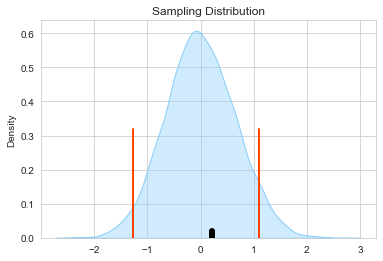

In [55]:
hyp_test(test_stat, sample_distribution_Ho)

In [56]:
diff2 = grade_after2 - grade_before

In [57]:
test_stat2 = np.mean(diff2)
test_stat2

4.069149842516363

In [58]:
dfp2 = generateSamples(diff2, num_samples=10000, sample_size=30)
print(dfp2.shape)
dfp2.head(2)

(30, 10000)


,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,Sample9,...,Sample9990,Sample9991,Sample9992,Sample9993,Sample9994,Sample9995,Sample9996,Sample9997,Sample9998,Sample9999
0,7.507750,13.096293,-0.047560,7.957508,4.914252,1.747946,8.334529,-1.174273,6.462155,3.092609,...,5.442397,11.245800,10.577096,3.324760,6.641396,0.336661,5.442397,3.092609,7.293114,4.233527
1,13.096293,4.346144,2.937403,5.442397,5.442397,0.902986,2.927282,-1.548209,10.314385,-3.078381,...,11.245800,4.346144,4.914252,-1.548209,-5.055008,7.743748,4.346144,5.442397,-0.198695,9.995366


In [59]:
sample_distribution_p2 = boot_mean(dfp2)

In [60]:
sample_distribution_Ho2 = sample_distribution_p2 - np.mean(sample_distribution_p2)

--- Bootstrap Hypothesis Test ---
    Sample Mean = 4.07
    p-value = 0.0


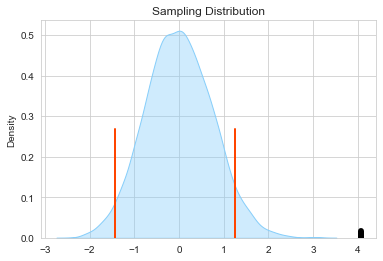

In [61]:
hyp_test(test_stat2, sample_distribution_Ho2)

### Summarizing using classes

`TwoPairSamplesHT` is the new class for the two paired samples hypothesis test using the bootstrapping method.

In [62]:
class TwoPairSamplesHT(gb.OneSampleHT):
    '''
    '''

    def __init__(self, sampleb, samplea,  num_samples=10000, sample_size=100):
        '''
        Here we are wotking with paired samples: "before" and "then"(after). We cannot break the link between both samples.
        sampleb: sample before 
        samplea: sample after         
        '''
        diff = samplea - sampleb
        super().__init__(diff, num_samples, sample_size, func=np.mean)
        self.obs_value = np.mean(samplea) - np.mean(sampleb)
        


    def twoPairSamplesHT(self, alpha=0.05, alternative='two-sided'):
        '''
        It computes the bootstrap two paired samples test.
        alpha: significance level
        alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
        '''
        #print('     Sample_before \t Sample_after')
        #print('Mean: %.2f \t %.2f' %(np.mean(self.sample1), np.mean(self.sample2)))
        #print('Var:  %.2f \t %.2f' %(np.var(self.sample1), np.var(self.sample2)))
        #print('n:    %i \t %i' %(len(self.sample1), len(self.sample2)))
        #sigHo = {'two-sided':' =', 'smaller':'>=', 'larger':'<='}
        sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
        print('--- Bootstrapping Method ---')
        print('    Ho: mean_before == mean_after')
        print('    Ha: mean_before', sigHa[alternative], 'mean_after')
        print('statistic: mean_after - mean_before')
        self.createSampleDistributionHo(0)
        p_val = self.getpValue(self.obs_value, alpha, alternative)
        print('statistic = %.2f \t p-value = %.4f' %(self.obs_value, p_val))

     
    def graphTwoSamplesHT(self, stat='mean', alpha=0.05, alternative='two-sided'):
        '''
        It computes the bootstrap two paired samples test and gets graphical results.
        stat: 'mean', 'median', 't'
        alpha: significance level
        alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
        '''
        #print('     Sample_before \t Sample_after')
        #print('Mean: %.2f \t %.2f' %(np.mean(self.sample1), np.mean(self.sample2)))
        #print('Var:  %.2f \t %.2f' %(np.var(self.sample1), np.var(self.sample2)))
        #print('n:    %i \t %i' %(len(self.sample1), len(self.sample2)))
        #sigHo = {'two-sided':' =', 'smaller':'>=', 'larger':'<='}
        sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
        print('--- Bootstrapping Method ---')
        print('    Ho: mean_before == mean_after')
        print('    Ha: mean_before', sigHa[alternative], 'mean_after')
        print('statistic: mean_before - mean_after')
        self.createSampleDistributionHo(0)
        p_val = self.graphpValue(self.obs_value, alpha, alternative)
        print('statistic = %.2f \t p-value = %.4f' %(self.obs_value, p_val))



In [63]:
MyP = TwoPairSamplesHT(grade_before, grade_after)

--- Bootstrapping Method ---
    Ho: mean_before == mean_after
    Ha: mean_before != mean_after
statistic: mean_before - mean_after
statistic = 0.22 	 p-value = 0.6596


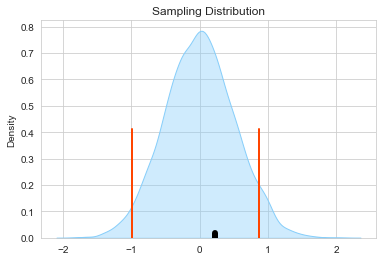

In [64]:
MyP.graphTwoSamplesHT()

In [65]:
MyP2 = TwoPairSamplesHT(grade_before, grade_after2)

--- Bootstrapping Method ---
    Ho: mean_before == mean_after
    Ha: mean_before != mean_after
statistic: mean_before - mean_after
statistic = 4.07 	 p-value = 0.0000


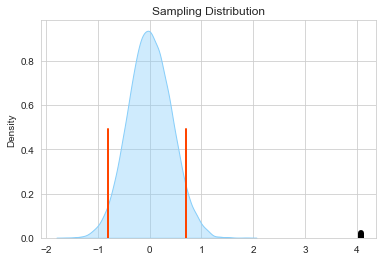

In [66]:
MyP2.graphTwoSamplesHT()